Fake News Detection using RNNs and Advanced NLP Techniques


1. Import Libraries and Load Data
----------------------------

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-09-29 23:21:11.678407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-29 23:21:11.715004: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-29 23:21:11.722917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-29 23:21:11.741261: I tensorflow/core/platform/cpu_feature_guard.cc:210

Lood Data

-------------------

In [2]:
# Load dataset
train = pd.read_csv("/workspaces/Data-analysis-2/Text_Analysis/train.csv")
test = pd.read_csv("/workspaces/Data-analysis-2/Text_Analysis/test.csv")

# Display first few rows of the dataset
train.head()


,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


2. Handling Missing Data

--------------------------


In [3]:
# Check for missing values
print("Total Missing Values Numbers of columns:")
missing_values = pd.DataFrame(train.isnull().sum())
missing_values.style.background_gradient(cmap="ocean")


Total Missing Values Numbers of columns:


,0
id,0
title,558
author,1957
text,39
label,0


Step 2: Drop Rows with Missing Values


In [4]:
# Drop rows with missing values in the 'title', 'author', or 'text' columns
train_clean = train.dropna(subset=['title', 'author', 'text'])

# Check the result to ensure missing values are gone
print(f"Remaining rows after dropping missing values: {train_clean.shape[0]}")


Remaining rows after dropping missing values: 18285


In [5]:
# Drop any remaining missing values 
train_clean = train_clean.dropna()

# Split features and labels
X = train_clean.drop("label", axis=1)
y = train_clean["label"]

# Reset index for messages (features)
X.reset_index(drop=True, inplace=True)

# Check the first few rows of cleaned data
print(X.head())
print(y.head())


   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  
0  House Dem Aide: We Didn’t Even See Comey’s Let...  
1  Ever get the feeling your life circles the rou...  
2  Why the Truth Might Get You Fired October 29, ...  
3  Videos 15 Civilians Killed In Single US Airstr...  
4  Print \nAn Iranian woman has been sentenced to...  
0    1
1    0
2    1
3    1
4    1
Name: label, dtype: int64


3.  Text Preprocessing

---------------------


In [6]:
from nltk.stem import WordNetLemmatizer
X = train_clean.drop("label", axis=1)
y = train_clean["label"]

# Reset index for 'X'
messages = X.reset_index(drop=True)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()
corpus = []

# Loop through each message in the 'title' column (or replace 'title' with another text column if needed)
for i in range(len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])  # Remove non-alphabetic characters
    review = review.lower()  # Convert to lowercase
    review = review.split()  # Tokenization
    
    # Lemmatization
    review = [lemmatizer.lemmatize(word) for word in review]
    review = ' '.join(review)
    
    corpus.append(review)

# Check the result
print(corpus[:5])  # Print the first 5 preprocessed texts


['house dem aide we didn t even see comey s letter until jason chaffetz tweeted it', 'flynn hillary clinton big woman on campus breitbart', 'why the truth might get you fired', 'civilian killed in single u airstrike have been identified', 'iranian woman jailed for fictional unpublished story about woman stoned to death for adultery']


In [7]:
print(review)

what keep the f alive


4. Data Visualization


--------------------------

Data visualization is a crucial aspect of data analysis. It helps to communicate insights and findings effectively to stakeholders

---------------------------


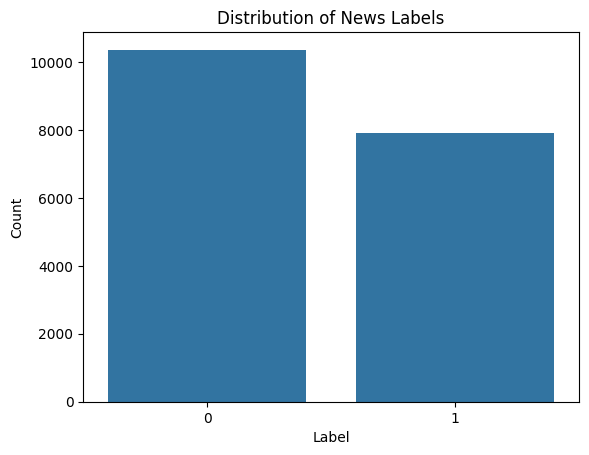

In [9]:
# Visualizing the distribution of labels
sns.countplot(x='label', data=train_clean)
plt.title('Distribution of News Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


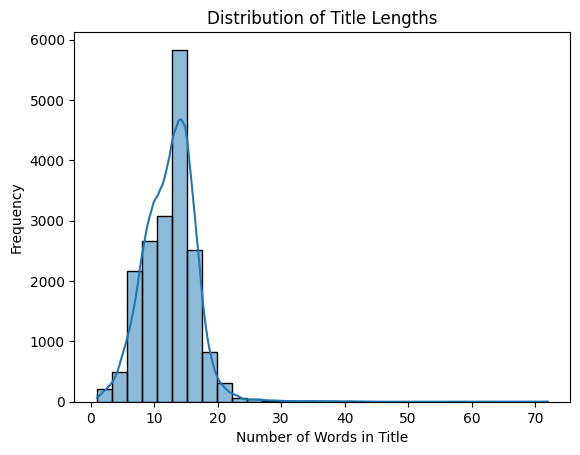

In [14]:
# Visualizing the length of titles in the dataset
train_clean['title_length'] = train_clean['title'].apply(lambda x: len(x.split()))
sns.histplot(train_clean['title_length'], bins=30, kde=True)
plt.title('Distribution of Title Lengths')
plt.xlabel('Number of Words in Title')
plt.ylabel('Frequency')
plt.show()


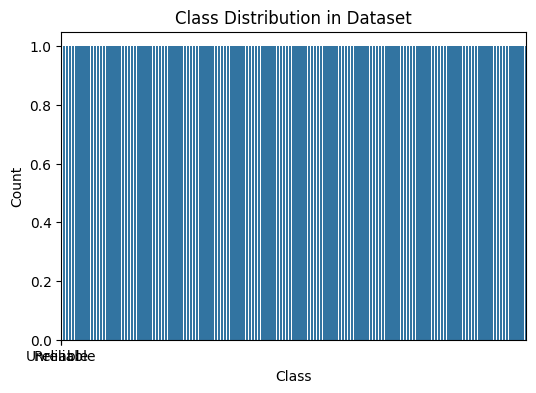

In [40]:
def plot_class_distribution(labels, title='Class Distribution'):
    plt.figure(figsize=(6, 4))
    sns.countplot(labels)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['Reliable', 'Unreliable'])
    plt.show()

plot_class_distribution(train_clean['label'], title='Class Distribution in Dataset')


5. Prepare Data for Modeling

--------------
Tokenization and Padding

----------------



In [15]:
# Vocabulary size
voc_size = 10000
sent_length = 20

tokenizer = Tokenizer(num_words=voc_size, oov_token="<OOV>")
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

# Pad sequences
X_final = pad_sequences(sequences, maxlen=sent_length, padding='post')
y_final = np.array(y)


Load Pre-trained Word Embeddings

------------------------


In [16]:
from gensim.models import KeyedVectors
import gensim.downloader as api

# Load pre-trained GloVe embeddings
embedding_model = api.load('glove-wiki-gigaword-100')


In [17]:
# Create embedding matrix
embedding_dim = 100

def create_embedding_matrix(word_index, embedding_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model:
            embedding_vector = embedding_model[word]
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.normal(0, 0.1, embedding_dim)
    return embedding_matrix

embedding_matrix = create_embedding_matrix(tokenizer.word_index,
  embedding_model,
  embedding_dim)


6. Train/Test Split

------------------------

In [18]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
X_final, y_final, test_size=0.33, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)


Training set size: (12250, 20)
Testing set size: (6035, 20)


7. Build and Train Models

----------------------------

Bidirectional LSTM Model


In [19]:
# Build the Bidirectional LSTM model
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
 output_dim=embedding_dim,
  weights=[embedding_matrix],
input_length=sent_length,
trainable=False))
model_bi_lstm.add(Bidirectional(LSTM(100)))
model_bi_lstm.add(Dense(1, activation='sigmoid'))

# Compile the model
model_bi_lstm.compile(optimizer='adam', loss='binary_crossentropy',
 metrics=['accuracy'])

# Train the model
history_bi_lstm = model_bi_lstm.fit(X_train, y_train, epochs=5,
  batch_size=64,
  validation_data=(X_test, y_test))


Epoch 1/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.8055 - loss: 0.3781 - val_accuracy: 0.9107 - val_loss: 0.1964
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9170 - loss: 0.1814 - val_accuracy: 0.9203 - val_loss: 0.1786
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9367 - loss: 0.1543 - val_accuracy: 0.9229 - val_loss: 0.1786
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9423 - loss: 0.1384 - val_accuracy: 0.9273 - val_loss: 0.1678
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9515 - loss: 0.1189 - val_accuracy: 0.9292 - val_loss: 0.1685


LSTM with Attention Mechanism


In [20]:
from keras_self_attention import SeqSelfAttention

# Build the LSTM model with attention
model_attention = Sequential()
model_attention.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                              output_dim=embedding_dim,
                              weights=[embedding_matrix],
                              input_length=sent_length,
                              trainable=False))
model_attention.add(Bidirectional(LSTM(64, return_sequences=True)))
model_attention.add(SeqSelfAttention(attention_activation='sigmoid'))
model_attention.add(tf.keras.layers.Flatten())
model_attention.add(Dense(1, activation='sigmoid'))

# Compile the model
model_attention.compile(optimizer='adam', loss='binary_crossentropy',
                        metrics=['accuracy'])

# Train the model
history_attention = model_attention.fit(X_train, y_train, epochs=5,
                                        batch_size=64,
                                        validation_data=(X_test, y_test))


Epoch 1/5


192/192 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.8137 - loss: 0.3617 - val_accuracy: 0.9042 - val_loss: 0.2184
Epoch 2/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9204 - loss: 0.1922 - val_accuracy: 0.9175 - val_loss: 0.1904
Epoch 3/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9314 - loss: 0.1623 - val_accuracy: 0.9278 - val_loss: 0.1760
Epoch 4/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9407 - loss: 0.1404 - val_accuracy: 0.9188 - val_loss: 0.1816
Epoch 5/5
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9517 - loss: 0.1157 - val_accuracy: 0.9316 - val_loss: 0.1650


8. Model Evaluation

----------------
Evaluate Bidirectional LSTM Model


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Bidirectional LSTM Model Accuracy: 0.93


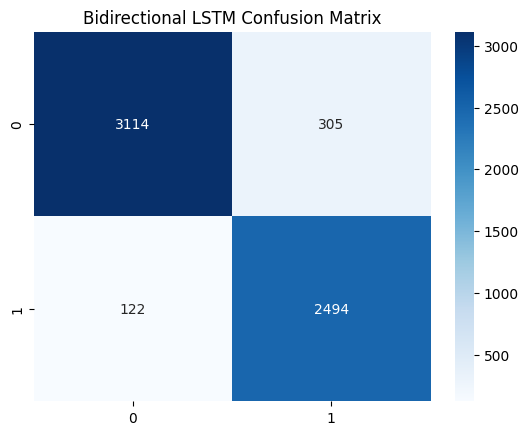

              precision    recall  f1-score   support

           0       0.96      0.91      0.94      3419
           1       0.89      0.95      0.92      2616

    accuracy                           0.93      6035
   macro avg       0.93      0.93      0.93      6035
weighted avg       0.93      0.93      0.93      6035



In [21]:
# Evaluate the model on the test set
y_pred_bi_lstm = (model_bi_lstm.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy_bi_lstm = accuracy_score(y_test, y_pred_bi_lstm)
print(f'Bidirectional LSTM Model Accuracy: {accuracy_bi_lstm:.2f}')

# Confusion matrix
conf_matrix_bi_lstm = confusion_matrix(y_test, y_pred_bi_lstm)
sns.heatmap(conf_matrix_bi_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Bidirectional LSTM Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_bi_lstm))


Evaluate Attention Model


189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Attention Model Accuracy: 0.93


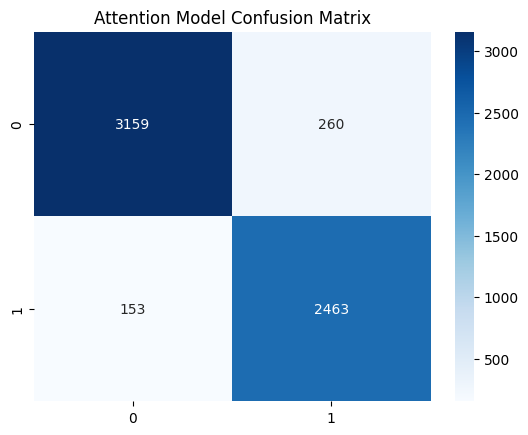

              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3419
           1       0.90      0.94      0.92      2616

    accuracy                           0.93      6035
   macro avg       0.93      0.93      0.93      6035
weighted avg       0.93      0.93      0.93      6035



In [22]:
# Evaluate the model on the test set
y_pred_attention = (model_attention.predict(X_test) > 0.5).astype(int)

# Calculate accuracy
accuracy_attention = accuracy_score(y_test, y_pred_attention)
print(f'Attention Model Accuracy: {accuracy_attention:.2f}')

# Confusion matrix
conf_matrix_attention = confusion_matrix(y_test, y_pred_attention)
sns.heatmap(conf_matrix_attention, annot=True, fmt='d', cmap='Blues')
plt.title('Attention Model Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_attention))


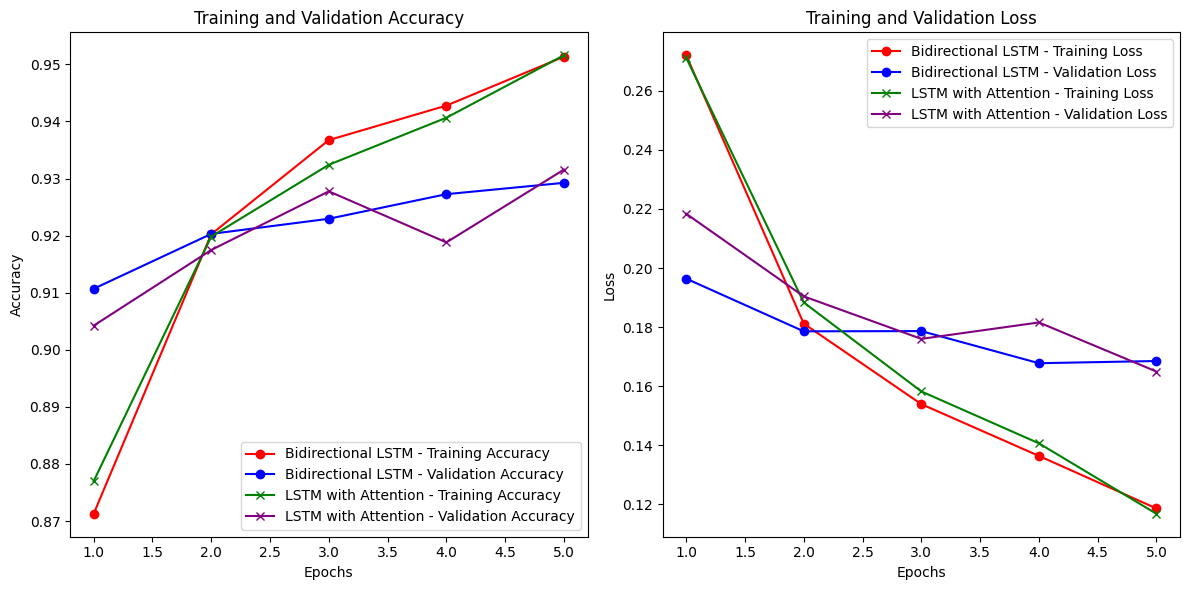

In [23]:
# Function to plot accuracy and loss for both models
def plot_training_history(history_bi_lstm, history_attention):
    epochs = range(1, 6)  # 5 epochs

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_bi_lstm.history['accuracy'], label='Bidirectional LSTM - Training Accuracy', color='red', marker='o')
    plt.plot(epochs, history_bi_lstm.history['val_accuracy'], label='Bidirectional LSTM - Validation Accuracy', color='blue', marker='o')
    plt.plot(epochs, history_attention.history['accuracy'], label='LSTM with Attention - Training Accuracy', color='green', marker='x')
    plt.plot(epochs, history_attention.history['val_accuracy'], label='LSTM with Attention - Validation Accuracy', color='purple', marker='x')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_bi_lstm.history['loss'], label='Bidirectional LSTM - Training Loss', color='red', marker='o')
    plt.plot(epochs, history_bi_lstm.history['val_loss'], label='Bidirectional LSTM - Validation Loss', color='blue', marker='o')
    plt.plot(epochs, history_attention.history['loss'], label='LSTM with Attention - Training Loss', color='green', marker='x')
    plt.plot(epochs, history_attention.history['val_loss'], label='LSTM with Attention - Validation Loss', color='purple', marker='x')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the training history
plot_training_history(history_bi_lstm, history_attention)


4. Plotting Training and Validation Accuracy and Loss


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


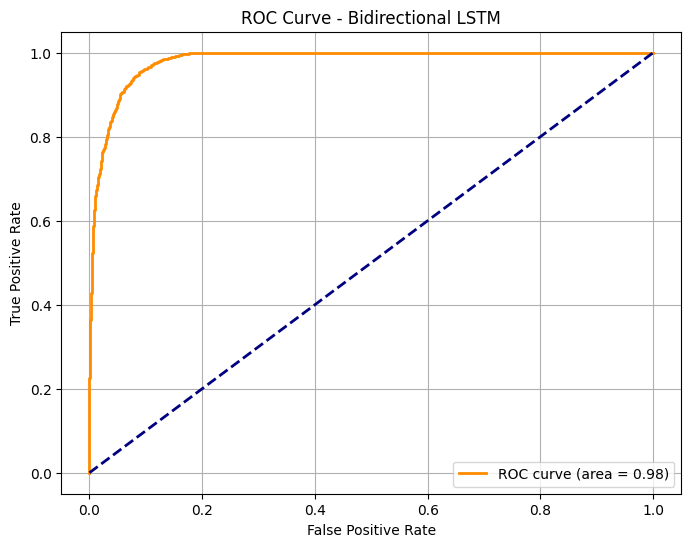

In [46]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_scores, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Get predicted probabilities
y_scores_bi_lstm = model_bi_lstm.predict(X_test).ravel()

# Plot ROC curve
plot_roc_curve(y_test, y_scores_bi_lstm, title='ROC Curve - Bidirectional LSTM')


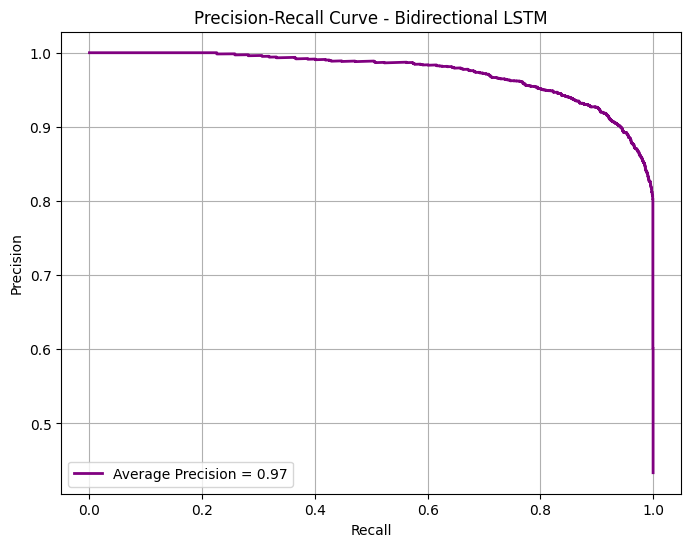

In [47]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='purple', lw=2,
             label='Average Precision = %0.2f' % average_precision)
    plt.title(title)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()

# Plot Precision-Recall curve
plot_precision_recall_curve(y_test, y_scores_bi_lstm, title='Precision-Recall Curve - Bidirectional LSTM')


9. Hyperparameter Tuning

--------------------

In [24]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
def build_and_train_model(units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=sent_length,
                        trainable=False))
    model.add(Bidirectional(LSTM(units=units)))
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=5, batch_size=64,
                        validation_data=(X_test, y_test), verbose=0)
    
    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Units: {units}, Dropout: {dropout_rate}, LR: {learning_rate}, Accuracy: {accuracy:.4f}')
    return accuracy
units_list = [50, 100]
dropout_list = [0.0, 0.2]
learning_rate_list = [1e-3, 1e-4]

best_accuracy = 0
best_params = {}

for units in units_list:
    for dropout_rate in dropout_list:
        for learning_rate in learning_rate_list:
            accuracy = build_and_train_model(units, dropout_rate, learning_rate)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'units': units, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}

print(f'Best Accuracy: {best_accuracy:.4f} with parameters: {best_params}')


189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Units: 50, Dropout: 0.0, LR: 0.001, Accuracy: 0.9234
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Units: 50, Dropout: 0.0, LR: 0.0001, Accuracy: 0.9112
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Units: 50, Dropout: 0.2, LR: 0.001, Accuracy: 0.9283
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Units: 50, Dropout: 0.2, LR: 0.0001, Accuracy: 0.9034
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Units: 100, Dropout: 0.0, LR: 0.001, Accuracy: 0.9263
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Units: 100, Dropout: 0.0, LR: 0.0001, Accuracy: 0.9143
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Units: 100, Dropout: 0.2, LR: 0.001, Accuracy: 0.9258
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Units: 100, Dropout: 0.2, LR: 0.0001, Accuracy: 0.9065
Best Accuracy: 0.9283 with parameters: {'units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.001}


In [52]:
def display_misclassified_samples(X_test, y_test, y_pred, tokenizer, num_samples=5):
    misclassified_indices = np.where(y_test != y_pred.squeeze())[0]
    print(f"Total misclassified samples: {len(misclassified_indices)}\n")

    oov_token_index = tokenizer.word_index.get(tokenizer.oov_token)
    oov_token_word = tokenizer.index_word.get(oov_token_index, '') if oov_token_index else ''

    for idx in misclassified_indices[:num_samples]:
        sequence = X_test[idx]
        words = []
        for idx_word in sequence:
            word = tokenizer.index_word.get(idx_word)
            if word is not None:
                words.append(word)
            elif tokenizer.oov_token is not None and oov_token_word:
                words.append(oov_token_word)
        text = ' '.join(words)
        actual_label = 'Unreliable' if y_test[idx] == 1 else 'Reliable'
        predicted_label = 'Unreliable' if y_pred[idx][0] == 1 else 'Reliable'
        print(f"Text: {text}")
        print(f"Actual Label: {actual_label}, Predicted Label: {predicted_label}\n")


In [50]:
reliable_texts = train_clean[train_clean['label'] == 0]['text']
unreliable_texts = train_clean[train_clean['label'] == 1]['text']


10. Cross-Validation

----------------


In [25]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for train_idx, test_idx in kfold.split(X_final):
    model_cv = clone_model(model_bi_lstm)
    model_cv.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['accuracy'])
    model_cv.fit(X_final[train_idx], y_final[train_idx],
                 epochs=3, batch_size=64, verbose=0)
    scores = model_cv.evaluate(X_final[test_idx], y_final[test_idx],
                               verbose=0)
    print(f'Fold Accuracy: {scores[1]*100:.2f}%')
    cv_scores.append(scores[1] * 100)

# Display average performance
print(f'Mean Accuracy: {np.mean(cv_scores):.2f}% '
      f'(± {np.std(cv_scores):.2f}%)')


Fold Accuracy: 88.62%
Fold Accuracy: 90.40%
Fold Accuracy: 90.81%
Fold Accuracy: 89.03%
Fold Accuracy: 85.86%
Mean Accuracy: 88.95% (± 1.74%)


11. Visualize Word Embeddings


----------------

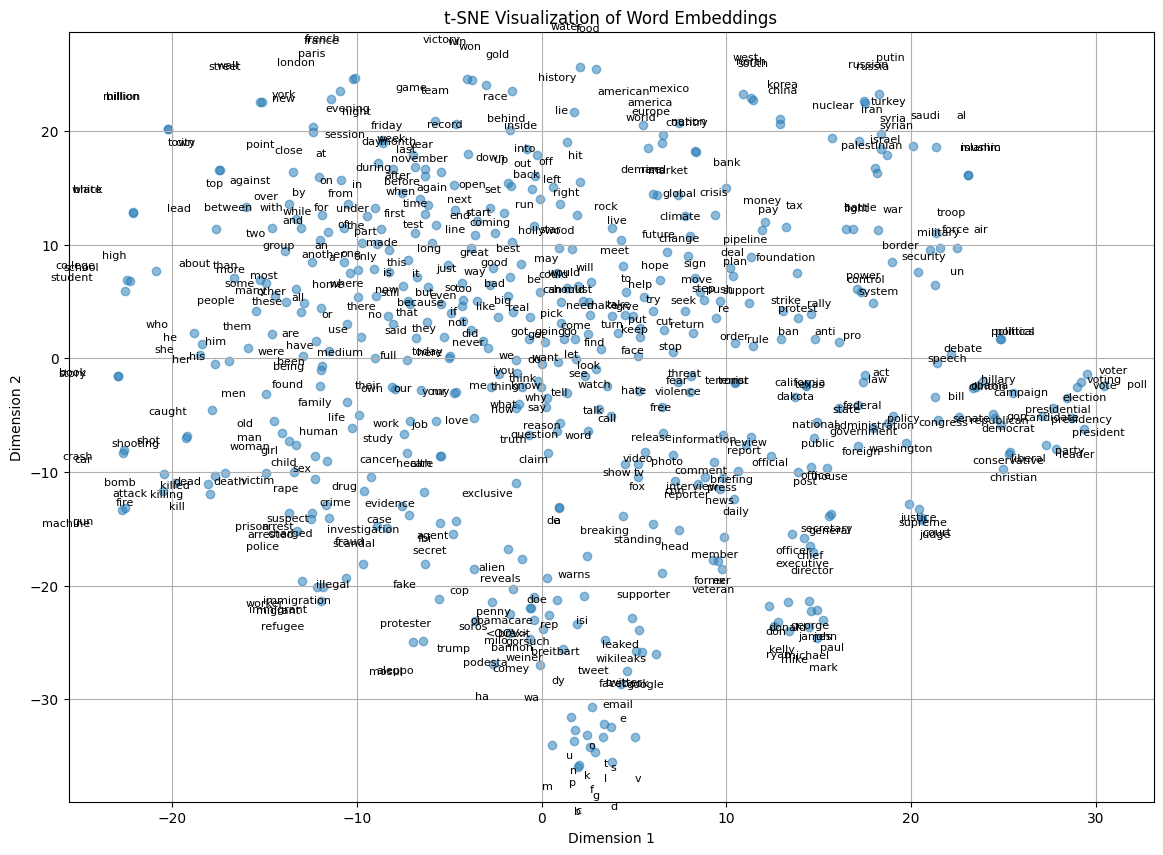

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Get word embeddings excluding the padding token
word_embeddings = embedding_matrix[1:]  # Assuming embedding_matrix[0] is for the padding token

# Create an index_to_word mapping
index_to_word = {index: word for word, index in tokenizer.word_index.items() if index != 0}

# Since embedding_matrix[1:] corresponds to indices starting from 1, sort the indices
sorted_indices = sorted(index_to_word.keys())

# Create a list of words sorted by their index to align with word_embeddings
words_sorted = [index_to_word[index] for index in sorted_indices]

# Reduce dimensions with t-SNE (limit to first 500 embeddings)
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(word_embeddings[:500])

# Update words list to match the embeddings used
words_to_plot = words_sorted[:500]

# Plot the embeddings
plt.figure(figsize=(14, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5)

for i, word in enumerate(words_to_plot):
    plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
                 textcoords='offset points', ha='right', va='bottom', fontsize=8)

plt.title('t-SNE Visualization of Word Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


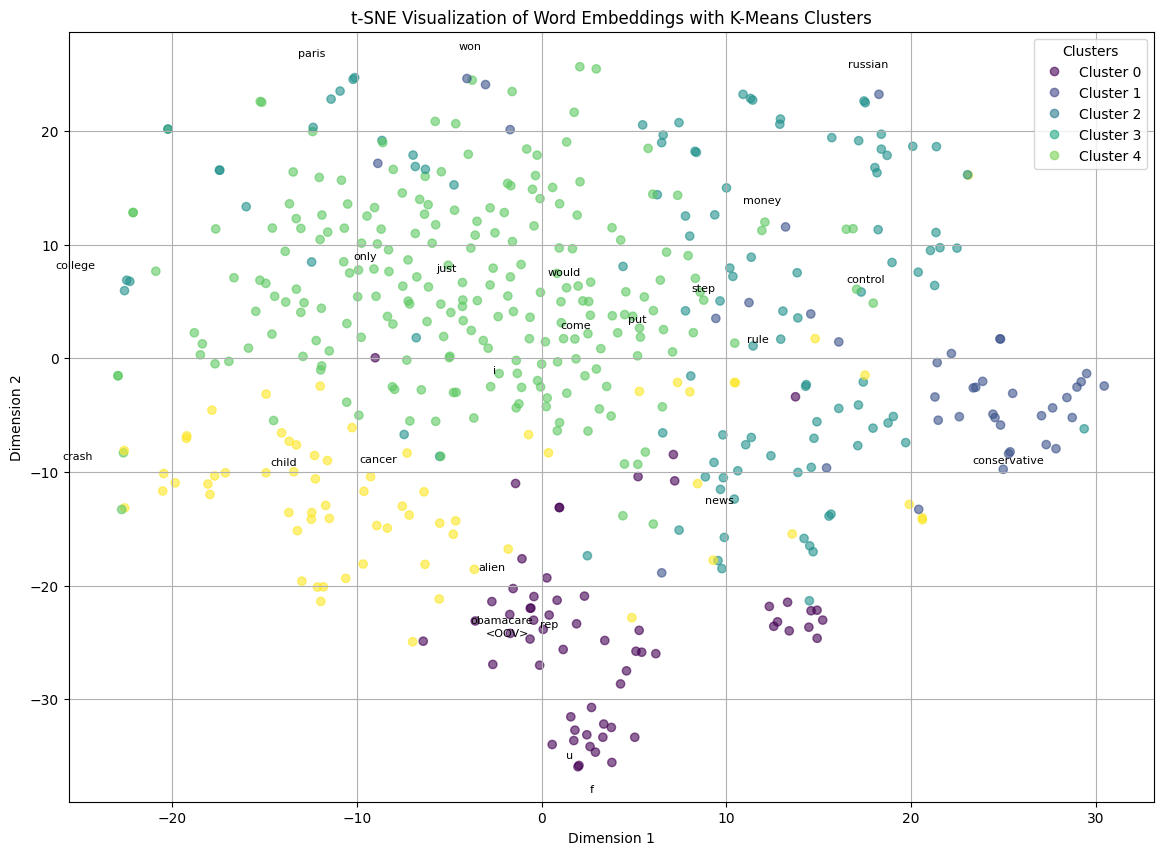

In [54]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

# Get word embeddings excluding the padding token
word_embeddings = embedding_matrix[1:]  # Exclude the embedding for index 0

# Create index_to_word mapping
index_to_word = {index: word for word, index in tokenizer.word_index.items() if index != 0}

# Sort indices to align words with embeddings
sorted_indices = sorted(index_to_word.keys())

# Create a list of words sorted by their index
words_sorted = [index_to_word[index] for index in sorted_indices]

# Limit to first 500 embeddings for visualization
num_embeddings = 500  # Adjust as needed
embeddings_to_use = word_embeddings[:num_embeddings]
words_to_plot = words_sorted[:num_embeddings]

# Cluster the embeddings
num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
cluster_labels = kmeans.fit_predict(embeddings_to_use)

# Reduce dimensions with t-SNE
tsne = TSNE(n_components=2, random_state=0)
embeddings_2d = tsne.fit_transform(embeddings_to_use)

# Plot the embeddings with cluster colors
plt.figure(figsize=(14, 10))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                      c=cluster_labels, cmap='viridis', alpha=0.6)

# Add a legend for clusters
handles, labels = scatter.legend_elements(prop='colors', num=num_clusters)
plt.legend(handles, [f'Cluster {i}' for i in range(num_clusters)], title='Clusters')

# Annotate a subset of words to avoid clutter
for i, word in enumerate(words_to_plot):
    if i % 20 == 0:  # Adjust this value to control annotation frequency
        plt.annotate(word, xy=(embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     textcoords='offset points', ha='right', va='bottom', fontsize=8)

plt.title('t-SNE Visualization of Word Embeddings with K-Means Clusters')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  # Import word_tokenize

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')
nltk.download('punkt')  # Ensure the punkt tokenizer is downloaded

# Define stopwords (you can add more custom stopwords if needed)
stop_words = set(stopwords.words('english'))

# Join all titles/texts into one large string and preprocess the text
all_text = ' '.join(messages['title'].astype(str))  # Or use 'text' column if needed
all_text = re.sub(r'[^a-zA-Z\s]', '', all_text.lower())  # Remove non-alphabetic characters, convert to lowercase

# Tokenize the words
words = word_tokenize(all_text)  # Ensure word_tokenize is correctly imported

# Remove stopwords and count word frequencies
filtered_words = [word for word in words if word not in stop_words]
word_freq = Counter(filtered_words)

# Get the most common words
most_common_words = word_freq.most_common(20)  # Top 20 most frequent words

# Convert to a dataframe for easy plotting
word_freq_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# Plot the most common words
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df, palette='Blues_d')
plt.title('Top 20 Most Frequent Words in Titles')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


In [27]:

import numpy as np
from lime.lime_text import LimeTextExplainer

# Ensure the tokenizer has index_word mapping
if not hasattr(tokenizer, 'index_word'):
    tokenizer.index_word = {v: k for k, v in tokenizer.word_index.items()}

# Function to convert sequences back to text without OOV tokens
def sequences_to_texts_no_oov(sequences, tokenizer):
    texts = []
    for sequence in sequences:
        words = []
        for idx in sequence:
            word = tokenizer.index_word.get(idx, '')
            if word != '<OOV>':
                words.append(word)
        texts.append(' '.join(words))
    return texts

# Define the class names
class_names = ['Reliable', 'Unreliable']

# Define the prediction function
def predict_fn(texts):
    # Tokenize and pad the sequences
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=sent_length, padding='post')
    # Get prediction probabilities
    preds = model_bi_lstm.predict(padded_sequences)
    # Return probability for each class
    return np.hstack([1 - preds, preds])

# Create the LIME text explainer
explainer = LimeTextExplainer(class_names=class_names)

# Select an instance to explain
idx = 0  # Change this index to select a different instance
sequence = X_test[idx:idx+1]
text_instance = sequences_to_texts_no_oov(sequence, tokenizer)[0]

# Generate explanation
explanation = explainer.explain_instance(
    text_instance, 
    predict_fn, 
    num_features=10,  # Number of features (words) to include in the explanation
    labels=[1]        # Class index to explain (1 for 'Unreliable', 0 for 'Reliable')
)

# Display explanation in notebook
explanation.show_in_notebook(text=True)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [57]:
from wordcloud import WordCloud

def plot_word_cloud(corpus, title='Word Cloud'):
    text = ' '.join(corpus)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

# Assuming 'train_clean' has a 'text' column with preprocessed text
plot_word_cloud(train_clean['text'], title='Word Cloud of News Titles')


: 